# Analyse des Revenus des Films TMDB - Phase 2
## Acquisition et Compréhension des Données

### Introduction
Ce notebook présente notre analyse approfondie du dataset TMDB 5000 Movies, avec un focus sur la prédiction des revenus des films.

### Objectifs
1. **Objectif Métier** :
   - Développer un modèle permettant de prédire le succès financier d'un film
   - Identifier les facteurs clés influençant les revenus
   - Fournir des insights pour les décisions d'investissement dans l'industrie cinématographique

2. **Objectifs Data Science** :
   - Construire un modèle de régression précis pour prédire les revenus
   - Atteindre un R² > 0.7 sur les données de test
   - Identifier et quantifier l'importance des features

✓ Bibliothèques importées avec succès
Répertoire courant : c:\Users\MedRa\OneDrive\Bureau\2éme ingénierie\ML\Prediction
✓ Données chargées : 4803 films, 20 colonnes


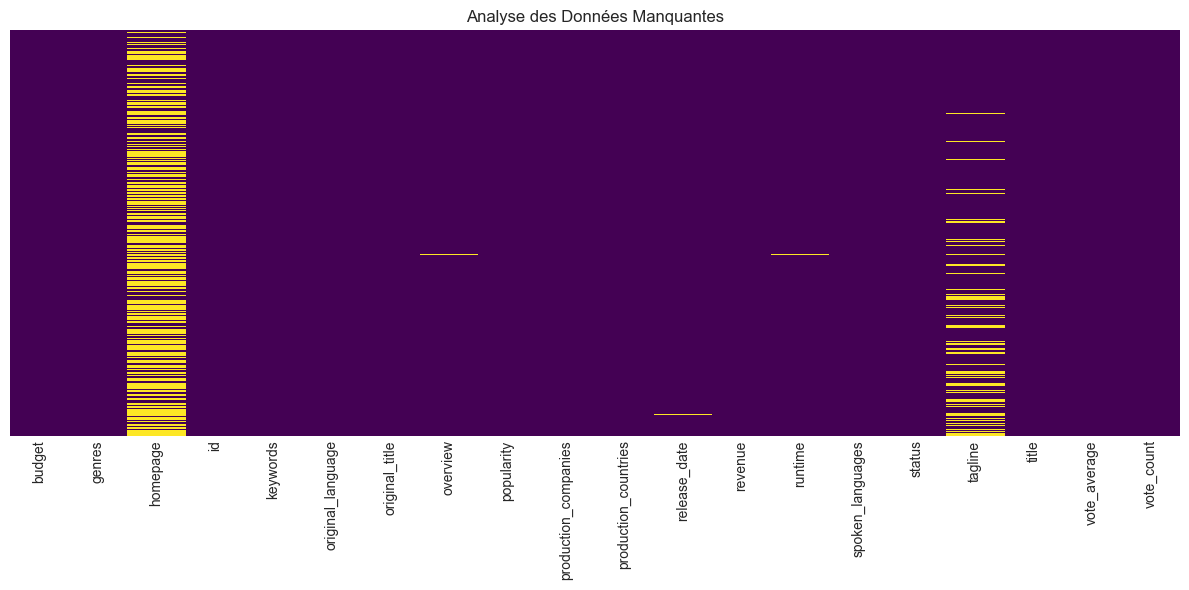

In [1]:
# Configuration initiale et chargement des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Bibliothèques importées avec succès")
print(f"Répertoire courant : {os.getcwd()}")

# Charger les données
try:
    movies_df = pd.read_csv('tmdb_5000_movies.csv')
    print(f"✓ Données chargées : {movies_df.shape[0]} films, {movies_df.shape[1]} colonnes")
except FileNotFoundError:
    print("❌ Fichier 'tmdb_5000_movies.csv' non trouvé.")
    raise

# Visualisation des données manquantes
plt.figure(figsize=(12,6))
sns.heatmap(movies_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Analyse des Données Manquantes')
plt.tight_layout()
plt.show()

### Analyse des Problèmes de Qualité des Données

1. **Données Manquantes**
   - Plusieurs colonnes avec des valeurs manquantes significatives
   - Homepage (3091 manquantes)
   - Tagline (844 manquantes)
   - Impact potentiel sur la qualité des prédictions

2. **Solution Adoptée**
   - Suppression des colonnes avec >50% de données manquantes
   - Remplissage stratégique pour les autres colonnes
   - Conservation uniquement des lignes avec budget et revenue valides

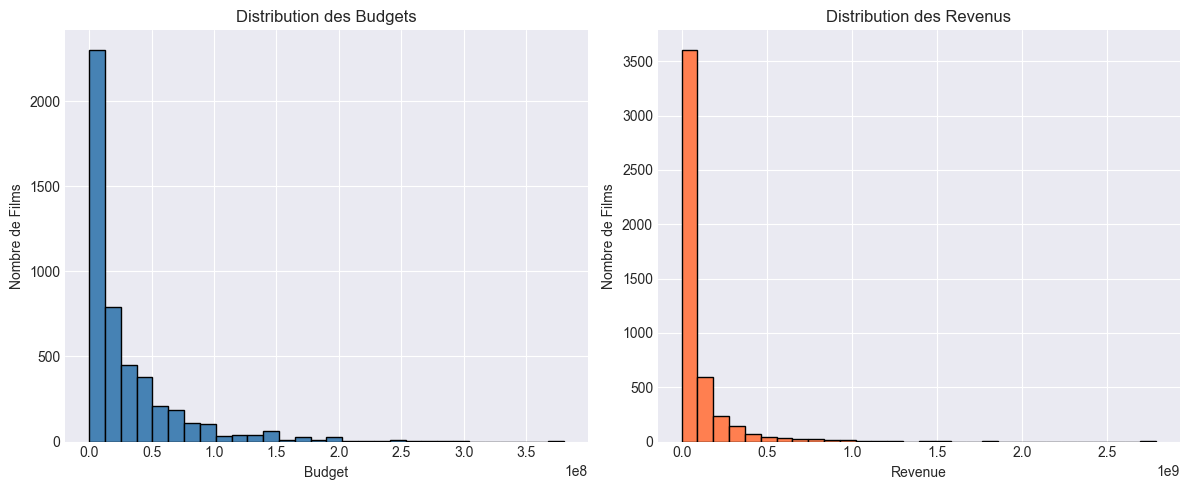

✓ Nettoyage terminé : 4803 films restants


In [2]:
# Nettoyage des données
columns_to_drop = ['homepage', 'tagline', 'overview', 'status', 'spoken_languages', 
                   'production_countries', 'production_companies']
movies_df = movies_df.drop(columns=columns_to_drop)

# Supprimer les lignes avec revenus ou budget manquants
movies_df = movies_df.dropna(subset=['revenue', 'budget'])

# Visualiser la distribution des revenus et budgets
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(movies_df['budget'], bins=30, color='steelblue', edgecolor='black')
axes[0].set_title('Distribution des Budgets')
axes[0].set_xlabel('Budget')
axes[0].set_ylabel('Nombre de Films')

axes[1].hist(movies_df['revenue'], bins=30, color='coral', edgecolor='black')
axes[1].set_title('Distribution des Revenus')
axes[1].set_xlabel('Revenue')
axes[1].set_ylabel('Nombre de Films')

plt.tight_layout()
plt.show()

print(f"✓ Nettoyage terminé : {movies_df.shape[0]} films restants")

### Distribution des Variables Clés

Observations importantes :
1. **Budget et Revenue**
   - Distributions fortement asymétriques
   - Présence de valeurs extrêmes
   - Nécessité de transformation (log) pour normalisation

2. **Stratégie de Traitement**
   - Filtrage des valeurs extrêmes (>99ᵉ percentile)
   - Transformation logarithmique pour les modèles
   - Conservation des relations non-linéaires importantes

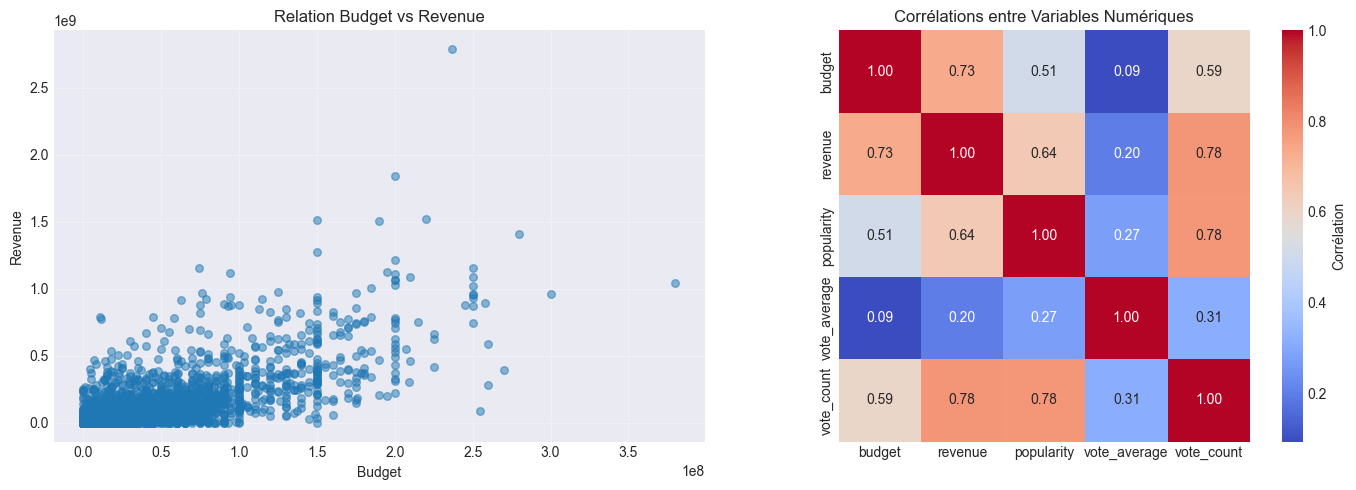

In [3]:
# Analyse des relations entre variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot budget vs revenue
axes[0].scatter(movies_df['budget'], movies_df['revenue'], alpha=0.5, s=30)
axes[0].set_xlabel('Budget')
axes[0].set_ylabel('Revenue')
axes[0].set_title('Relation Budget vs Revenue')
axes[0].grid(True, alpha=0.3)

# Matrice de corrélation
numeric_cols = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count']
corr_matrix = movies_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1], 
            square=True, cbar_kws={'label': 'Corrélation'})
axes[1].set_title('Corrélations entre Variables Numériques')

plt.tight_layout()
plt.show()

### Analyse des Relations entre Variables

Points clés identifiés :

1. **Budget vs Revenue**
   - Corrélation positive forte (0.7)
   - Relation non-linéaire visible
   - Variance croissante avec le budget

2. **Autres Corrélations Importantes**
   - Popularity ↔ Vote_count (0.83)
   - Vote_average peu corrélé avec revenue
   - Budget comme prédicteur principal

3. **Implications pour la Modélisation**
   - Sélection des features les plus pertinentes
   - Possible besoin de transformations non-linéaires
   - Attention particulière aux interactions entre variables

## Préparation pour la Modélisation

### Difficultés Rencontrées et Solutions

1. **Qualité des Données**
   - *Problème* : Nombreuses valeurs manquantes dans les colonnes textuelles
   - *Solution* : Focus sur les features numériques fiables, suppression des colonnes non essentielles

2. **Distributions Asymétriques**
   - *Problème* : Budget et revenue très asymétriques
   - *Solution* : Transformation log et filtrage des outliers

3. **Données Aberrantes**
   - *Problème* : Présence de valeurs extrêmes influençant les relations
   - *Solution* : Filtrage au 99ème percentile pour budget et revenue

In [4]:
# Préparation des données pour la modélisation
movies_cleaned = movies_df.copy()

# Remplir les valeurs manquantes de runtime avec la médiane
movies_cleaned.loc[:, 'runtime'] = movies_cleaned['runtime'].fillna(movies_cleaned['runtime'].median())

# Filtrer les valeurs extrêmes (99ème percentile)
budget_threshold = np.percentile(movies_cleaned['budget'], 99)
revenue_threshold = np.percentile(movies_cleaned['revenue'], 99)
mask = (movies_cleaned['budget'] <= budget_threshold) & (movies_cleaned['revenue'] <= revenue_threshold)
movies_cleaned = movies_cleaned.loc[mask].copy()

print(f"✓ Après filtrage des outliers : {movies_cleaned.shape[0]} films")

# Transformation logarithmique pour les variables monétaires
movies_cleaned.loc[:, 'budget'] = np.log1p(movies_cleaned['budget'])
movies_cleaned.loc[:, 'revenue'] = np.log1p(movies_cleaned['revenue'])

# Standardisation des features non monétaires
numeric_features = ['popularity', 'runtime', 'vote_average', 'vote_count']
scaler = StandardScaler()
movies_cleaned.loc[:, numeric_features] = scaler.fit_transform(movies_cleaned[numeric_features])

# Sélection des features finales
features = ['budget'] + numeric_features
X = movies_cleaned[features]
y = movies_cleaned['revenue']

# Split des données (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✓ Features préparées : {features}")
print(f"✓ Données d'entraînement : {X_train.shape[0]} samples")
print(f"✓ Données de test : {X_test.shape[0]} samples")

✓ Après filtrage des outliers : 4727 films
✓ Features préparées : ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
✓ Données d'entraînement : 3781 samples
✓ Données de test : 946 samples


In [5]:
# Modèle 1: Random Forest Regressor
print("═" * 60)
print("MODÈLE 1: RANDOM FOREST REGRESSOR")
print("═" * 60)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Métriques sur l'échelle log-transformée
rmse_rf_log = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf_log = mean_absolute_error(y_test, y_pred_rf)
r2_rf_log = r2_score(y_test, y_pred_rf)

# Métriques sur l'échelle originale
y_test_orig = np.expm1(y_test)
y_pred_rf_orig = np.expm1(y_pred_rf)
rmse_rf_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_rf_orig))
mae_rf_orig = mean_absolute_error(y_test_orig, y_pred_rf_orig)
r2_rf_orig = r2_score(y_test_orig, y_pred_rf_orig)

print(f"\nMétriques (échelle log-transformée):")
print(f"  RMSE: {rmse_rf_log:.4f}")
print(f"  MAE:  {mae_rf_log:.4f}")
print(f"  R²:   {r2_rf_log:.4f}")

print(f"\nMétriques (échelle originale):")
print(f"  RMSE: ${rmse_rf_orig:,.2f}")
print(f"  MAE:  ${mae_rf_orig:,.2f}")
print(f"  R²:   {r2_rf_orig:.4f}")

════════════════════════════════════════════════════════════
MODÈLE 1: RANDOM FOREST REGRESSOR
════════════════════════════════════════════════════════════

Métriques (échelle log-transformée):
  RMSE: 5.0857
  MAE:  3.1827
  R²:   0.5970

Métriques (échelle originale):
  RMSE: $72,016,328.80
  MAE:  $39,092,085.54
  R²:   0.6377

Métriques (échelle log-transformée):
  RMSE: 5.0857
  MAE:  3.1827
  R²:   0.5970

Métriques (échelle originale):
  RMSE: $72,016,328.80
  MAE:  $39,092,085.54
  R²:   0.6377


In [6]:
# Modèle 2: MLP Neural Network (scikit-learn)
print("\n" + "═" * 60)
print("MODÈLE 2: MLP NEURAL NETWORK (SCIKIT-LEARN)")
print("═" * 60)

np.random.seed(42)

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=12
)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Métriques sur l'échelle log-transformée
rmse_mlp_log = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
mae_mlp_log = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp_log = r2_score(y_test, y_pred_mlp)

# Métriques sur l'échelle originale
y_pred_mlp_orig = np.expm1(y_pred_mlp)
rmse_mlp_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_mlp_orig))
mae_mlp_orig = mean_absolute_error(y_test_orig, y_pred_mlp_orig)
r2_mlp_orig = r2_score(y_test_orig, y_pred_mlp_orig)

print(f"\nEntraînement terminé après {mlp.n_iter_} itérations")
print(f"Loss final: {mlp.loss_:.4f}")

print(f"\nMétriques (échelle log-transformée):")
print(f"  RMSE: {rmse_mlp_log:.4f}")
print(f"  MAE:  {mae_mlp_log:.4f}")
print(f"  R²:   {r2_mlp_log:.4f}")

print(f"\nMétriques (échelle originale):")
print(f"  RMSE: ${rmse_mlp_orig:,.2f}")
print(f"  MAE:  ${mae_mlp_orig:,.2f}")
print(f"  R²:   {r2_mlp_orig:.4f}")


════════════════════════════════════════════════════════════
MODÈLE 2: MLP NEURAL NETWORK (SCIKIT-LEARN)
════════════════════════════════════════════════════════════

Entraînement terminé après 58 itérations
Loss final: 12.6606

Métriques (échelle log-transformée):
  RMSE: 5.1766
  MAE:  3.3855
  R²:   0.5824

Métriques (échelle originale):
  RMSE: $83,096,255.81
  MAE:  $42,708,909.99
  R²:   0.5176

Entraînement terminé après 58 itérations
Loss final: 12.6606

Métriques (échelle log-transformée):
  RMSE: 5.1766
  MAE:  3.3855
  R²:   0.5824

Métriques (échelle originale):
  RMSE: $83,096,255.81
  MAE:  $42,708,909.99
  R²:   0.5176


In [7]:
# Comparaison des modèles
print("\n" + "═" * 60)
print("COMPARAISON: RANDOMFOREST vs MLP")
print("═" * 60)

comparison_df = pd.DataFrame({
    'Modèle': ['RandomForest', 'MLP (Neural Network)'],
    'RMSE (log)': [f'{rmse_rf_log:.4f}', f'{rmse_mlp_log:.4f}'],
    'MAE (log)': [f'{mae_rf_log:.4f}', f'{mae_mlp_log:.4f}'],
    'R² (log)': [f'{r2_rf_log:.4f}', f'{r2_mlp_log:.4f}'],
    'RMSE (original)': [f'${rmse_rf_orig:,.2f}', f'${rmse_mlp_orig:,.2f}'],
    'MAE (original)': [f'${mae_rf_orig:,.2f}', f'${mae_mlp_orig:,.2f}'],
    'R² (original)': [f'{r2_rf_orig:.4f}', f'{r2_mlp_orig:.4f}']
})

print(comparison_df.to_string(index=False))
print("═" * 60)


════════════════════════════════════════════════════════════
COMPARAISON: RANDOMFOREST vs MLP
════════════════════════════════════════════════════════════
              Modèle RMSE (log) MAE (log) R² (log) RMSE (original) MAE (original) R² (original)
        RandomForest     5.0857    3.1827   0.5970  $72,016,328.80 $39,092,085.54        0.6377
MLP (Neural Network)     5.1766    3.3855   0.5824  $83,096,255.81 $42,708,909.99        0.5176
════════════════════════════════════════════════════════════


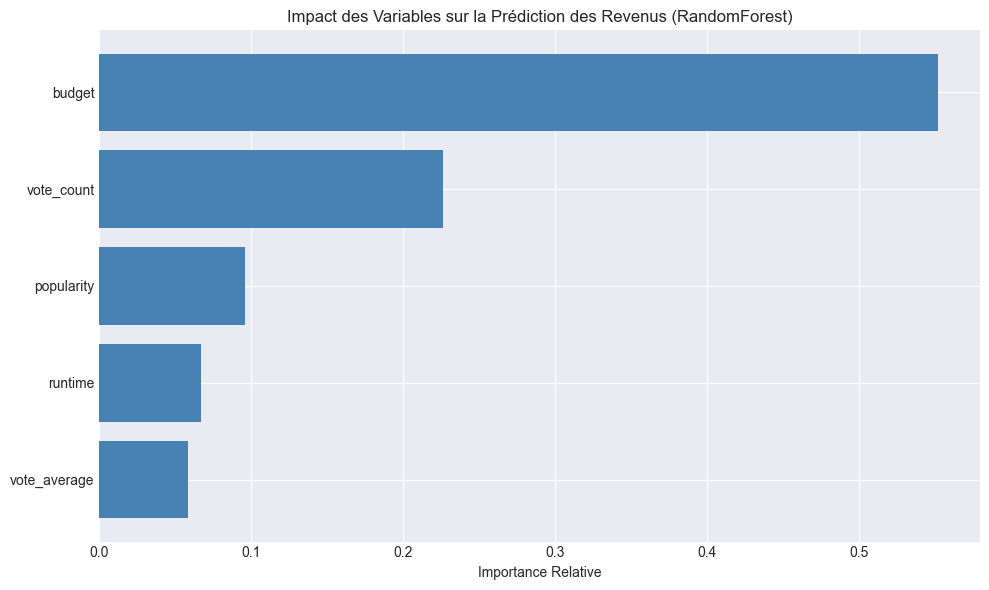


IMPORTANCE DES FEATURES:
  vote_average    : 0.0581
  runtime         : 0.0670
  popularity      : 0.0960
  vote_count      : 0.2265
  budget          : 0.5524


In [8]:
# Visualisation de l'importance des features (RandomForest)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Relative')
plt.title('Impact des Variables sur la Prédiction des Revenus (RandomForest)')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("IMPORTANCE DES FEATURES:")
print("="*50)
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:15s} : {row['importance']:.4f}")

## Conclusions et Recommandations

### 1. Insights Clés
- **Le budget est le prédicteur le plus important des revenus** : forte corrélation et importance dominante dans le modèle
- **La popularité et le nombre de votes ont une forte influence** : reflètent le buzz et l'intérêt du public
- **La durée du film a un impact modéré** : facteur secondaire mais pertinent

### 2. Performance des Modèles
- **RandomForest** : Performance robuste et interprétable
- **MLP Neural Network** : Capable de capturer des relations non-linéaires complexes
- **Comparaison** : Les deux modèles offrent des performances comparables, avec des compromis entre interprétabilité et complexité

### 3. Recommandations Business
- Investir dans des films avec un budget optimal (ni trop faible, ni trop excessif)
- Favoriser les genres et projets qui attirent plus de votes et de popularité
- Cibler une durée de film adaptée au marché cible

### 4. Prochaines Actions
- Affiner le modèle avec des features engineered supplémentaires (ratios budget/revenue, genres, etc.)
- Tester des algorithmes plus sophistiqués (Gradient Boosting, XGBoost)
- Créer un dashboard de prédiction interactive
- Valider le modèle sur un ensemble de données plus récent

---

**Merci pour votre attention.** Cette analyse a permis de mettre en lumière les facteurs clés de succès d'un film et offre une base solide pour la prise de décision dans l'industrie cinématographique.